# Requirements

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [3]:
# Add as many imports as you need.

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **count of page loads**. Your task involves employing bagging and boosting methods to forecast the **count of page loads**. To accomplish this, you will use data from the preceding three days, consisting of **count of page loads**, **count of unique visits**, **count of first time-visits**, **count of returning visits**, and the current **day**.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Website Visitors Dataset

## Downloading the Website Visitors Dataset

In [4]:
!gdown 1h1P3NboXKbWNngqgCB1i4bHFRcv7uDJe # Download the dataset.

usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--fuzzy] [--id] [--proxy PROXY]
             [--speed SPEED] [--no-cookies] [--no-check-certificate]
             [--continue] [--folder] [--remaining-ok] [--format FORMAT]
             [--user-agent USER_AGENT]
             url_or_id
gdown: error: unrecognized arguments: # Download the dataset.


## Exploring the Website Visitors Dataset
This datatset consists of daily counts of page loads, unique visitors, first-time visitors, and returning visitors for an academic teaching notes website. The dataset contains 2167 rows spanning from September 14, 2014, to August 19, 2020. A visit is defined as a series of hits on one or more pages by the same user on a given day, identified by IP address. Shared IP addresses are considered a single user. A visit is "unique" if a hit from the same IP address hasn't occurred within the last 6 hours. Returning visitors are identified by cookies, and the rest are classified as first-time visitors. The unique visitor count is the sum of returning and first-time visitors.

The dataset consists of the following columns:
- date - date in mm/dd/yyyy format,
- day_of_week - day of the week in text form (Monday, Tuesday, etc.),
- page_loads - daily number of pages loaded,
- unique_visits - daily number of visitors from IP addresses with no hits in over 6 hours,
- first_time_visits - number of unique visitors without a identifying cookie, and
- returning_visits - number of unique visitors minus first-time visitors.

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [3]:
# Write your code here. Add as many boxes as you need.
data = pd.read_csv('website-visitors.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               2167 non-null   object 
 1   day_of_week        2167 non-null   object 
 2   page_loads         2167 non-null   float64
 3   unique_visits      2167 non-null   float64
 4   first_time_visits  2167 non-null   float64
 5   returning_visits   2167 non-null   float64
dtypes: float64(4), object(2)
memory usage: 101.7+ KB


In [7]:
data.isnull().sum()

date                 0
day_of_week          0
page_loads           0
unique_visits        0
first_time_visits    0
returning_visits     0
dtype: int64

Explore the dataset using visualizations of your choice.

In [9]:
import matplotlib.pyplot as plt

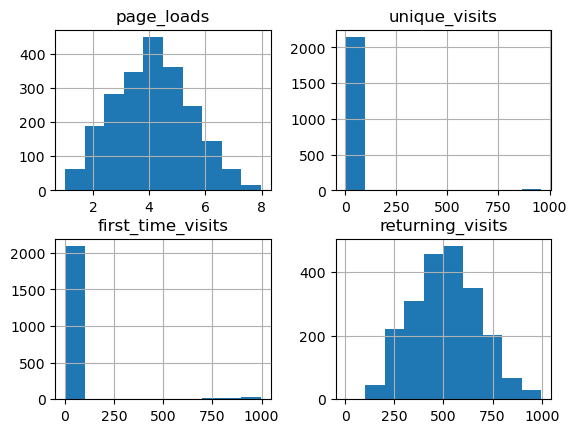

In [11]:
# Write your code here. Add as many boxes as you need.
data.hist()
plt.show()

In [13]:
data.head()

,date,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits
0,9/14/2014,Sunday,2.146,1.582,1.430,152.0
1,9/15/2014,Monday,3.621,2.528,2.297,231.0
2,9/16/2014,Tuesday,3.698,2.630,2.352,278.0
3,9/17/2014,Wednesday,3.667,2.614,2.327,287.0
4,9/18/2014,Thursday,3.316,2.366,2.130,236.0


Encode the categorical features.

In [15]:
# Write your code here. Add as many boxes as you need.
label = LabelEncoder()
data['day_of_week'] = label.fit_transform(data['day_of_week'])

In [17]:
data.head()

,date,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits
0,9/14/2014,3,2.146,1.582,1.430,152.0
1,9/15/2014,1,3.621,2.528,2.297,231.0
2,9/16/2014,5,3.698,2.630,2.352,278.0
3,9/17/2014,6,3.667,2.614,2.327,287.0
4,9/18/2014,4,3.316,2.366,2.130,236.0


In [19]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2167 entries, 2014-09-14 to 2020-08-19
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   day_of_week        2167 non-null   int32  
 1   page_loads         2167 non-null   float64
 2   unique_visits      2167 non-null   float64
 3   first_time_visits  2167 non-null   float64
 4   returning_visits   2167 non-null   float64
dtypes: float64(4), int32(1)
memory usage: 93.1 KB


In [21]:
data.head()

,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits
date,,,,,
2014-09-14,3,2.146,1.582,1.430,152.0
2014-09-15,1,3.621,2.528,2.297,231.0
2014-09-16,5,3.698,2.630,2.352,278.0
2014-09-17,6,3.667,2.614,2.327,287.0
2014-09-18,4,3.316,2.366,2.130,236.0


# Feauture Extraction
Apply a lag of one, two, and three days to each chosen feature (except `day_of_week`), creating a set of features representing the statistics from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [23]:
# Write your code here. Add as many boxes as you need.
for i in range(1, 4):
        data[f'page_loads_{i}'] = data['page_loads'].shift(i)
        data[f'unique_visits_{i}'] = data['unique_visits'].shift(i)
        data[f'first_time_visits_{i}'] = data['first_time_visits'].shift(i)
        data[f'returning_visits_{i}'] = data['returning_visits'].shift(i)

data = data.dropna(axis=0)
data = data.drop(['unique_visits','first_time_visits','returning_visits'], axis= 1)
data.sample(5)

,day_of_week,page_loads,page_loads_1,unique_visits_1,first_time_visits_1,returning_visits_1,page_loads_2,unique_visits_2,first_time_visits_2,returning_visits_2,page_loads_3,unique_visits_3,first_time_visits_3,returning_visits_3
date,,,,,,,,,,,,,,
2016-04-13,6,6.495,6.298,4.626,3.769,857.0,6.265,4.503,3.667,836.0,4.071,2.864,2.330,534.0
2017-08-13,3,1.530,1.240,888.000,669.000,219.0,2.073,1.498,1.121,377.0,2.670,1.864,1.463,401.0
2018-01-16,5,4.033,3.950,2.612,2.065,547.0,2.515,1.711,1.393,318.0,1.998,1.373,1.128,245.0
2020-05-28,4,4.939,5.242,4.105,3.474,631.0,5.224,4.069,3.416,653.0,4.639,3.610,3.054,556.0
2020-03-21,2,2.701,3.322,2.647,2.239,408.0,3.678,2.883,2.471,412.0,3.748,2.976,2.508,468.0


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [25]:
# Write your code here. Add as many boxes as you need.
input = data.drop(['page_loads'], axis=1)
target = data['page_loads']

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(input, target, test_size=0.2)

In [29]:
X_train

,day_of_week,page_loads_1,unique_visits_1,first_time_visits_1,returning_visits_1,page_loads_2,unique_visits_2,first_time_visits_2,returning_visits_2,page_loads_3,unique_visits_3,first_time_visits_3,returning_visits_3
date,,,,,,,,,,,,,
2018-01-02,5,1.709,1.120,878.000,242.0,1.339,923.000,724.000,199.0,1.546,1.071,839.000,232.0
2018-11-24,2,4.062,2.892,2.347,545.0,4.453,3.186,2.592,594.0,5.471,3.904,3.194,710.0
2016-11-22,5,6.336,4.693,3.788,905.0,4.647,3.426,2.777,649.0,3.501,2.580,2.136,444.0
2017-11-23,4,3.588,2.625,2.078,547.0,4.277,3.026,2.419,607.0,4.170,3.135,2.555,580.0
2015-06-07,3,2.422,1.673,1.336,337.0,3.608,2.523,2.068,455.0,4.431,3.173,2.652,521.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-26,0,4.128,2.730,2.210,520.0,4.498,3.022,2.481,541.0,4.531,3.139,2.566,573.0
2019-10-30,6,5.821,4.140,3.576,564.0,5.749,4.120,3.529,591.0,3.901,2.854,2.460,394.0
2015-10-03,2,3.443,2.598,2.196,402.0,4.619,3.365,2.876,489.0,4.969,3.703,3.182,521.0


## Ensemble Learning Methods

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

In [31]:
# Write your code here. Add as many boxes as you need.
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100,max_depth=5)
rfr.fit(X_train, Y_train)

RandomForestRegressor(max_depth=5)

Use the trained model to make predictions for the test set.

In [33]:
# Write your code here. Add as many boxes as you need.
y_pred = rfr.predict(X_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [37]:
# Write your code here. Add as many boxes as you need.
print(r2_score(Y_test,y_pred))

0.9068788927421512


### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [39]:
from xgboost import XGBRegressor

In [41]:
# Write your code here. Add as many boxes as you need.
xgb = XGBRegressor(n_estimators=100,max_depth=5,learning_rate=0.1)
xgb.fit(X_train,Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Use the trained model to make predictions for the test set.

In [43]:
# Write your code here. Add as many boxes as you need.
y_pred = xgb.predict(X_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [46]:
# Write your code here. Add as many boxes as you need.
print(r2_score(Y_test,y_pred))

0.9409157561937265


# Laboratory Exercise - Bonus Task (+ 2 points)

As part of the bonus task in this laboratory assignment, your objective is to fine-tune the number of estimators (`n_estimators`) for the XGBoost model using a cross-validation with grid search and time series split. This involves systematically experimenting with various values for `n_estimators` and evaluating the model's performance using cross-validation. Upon determining the most suitable `n_estimators` value, evaluate the model's performance on a test set for final assessment.

Hints:
- For grid search use the `GridCVSearch` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.
- For cross-validation use the `TimeSeriesSplit` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html.

## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**

In [48]:
# Write your code here. Add as many boxes as you need.
X_train, X_test, Y_train, Y_test = train_test_split(input, target, test_size=0.1)

## Fine-tuning the XGBoost Hyperparameter
Experiment with various values for `n_estimators` and evaluate the model's performance using cross-validation.

In [53]:
# Write your code here. Add as many boxes as you need.
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

param_grid = {
    'n_estimators': [25, 50, 100, 150] 
}
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(estimator=xgb,param_grid=param_grid,scoring='r2')
grid.fit(X_train, Y_train)

print("Best Parameters found:", grid.best_params_)
print("Best R² Score:", grid.best_score_)

Best Parameters found: {'n_estimators': 100}
Best R² Score: 0.9381101927983952


## Final Assessment of the Model Performance
Upon determining the most suitable `n_estimators` value, evaluate the model's performance on a test set for final assessment.

In [59]:
# Write your code here. Add as many boxes as you need.
from sklearn.metrics import mean_squared_error, r2_score


best_xgb_model = grid.best_estimator_
y_pred = best_xgb_model.predict(X_test)

mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print("\nFinal Model Assessment:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")



Final Model Assessment:
Mean Squared Error (MSE): 0.11301895732240663
R² Score: 0.9363410354007817
